# Phase 4: Model Selection
Tori St. John - November 2025

## Loading the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# load the data
csv_path = "data/cardio_train 2.csv"
df = pd.read_csv(csv_path, sep=";")
print('Shape:', df.shape)
df.head()

Shape: (70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## Cleaning up the data
Gotta remove those weird blood pressure values again

In [2]:
# remove the weird values
df = df[(df['ap_hi'] > 0) & (df['ap_hi'] < 300)]
df = df[(df['ap_lo'] > 0) & (df['ap_lo'] < 200)]
df = df[df['ap_hi'] > df['ap_lo']]  # systolic should be > diastolic

print('After cleaning:', df.shape)

After cleaning: (68709, 13)


## Setting up X and Y

In [3]:
# these are my 11 features
feature_cols = ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 
                'cholesterol', 'gluc', 'smoke', 'alco', 'active']

X = df[feature_cols].values
Y = df['cardio'].values

print('X shape:', X.shape)
print('Y shape:', Y.shape)
print('Positive class ratio:', np.mean(Y))

X shape: (68709, 11)
Y shape: (68709,)
Positive class ratio: 0.49470957225399875


## Shuffling everything

In [4]:
# combine X and Y so I can shuffle them together
dataset = np.column_stack((X, Y))
print('Dataset shape before shuffle:', dataset.shape)

# shuffle it up
np.random.seed(42)  # so results are the same each time
np.random.shuffle(dataset)

print('Shuffled!')

Dataset shape before shuffle: (68709, 12)
Shuffled!


## Splitting into training and validation
80/20 split like usual

In [5]:
# figure out where to split
index_20percent = int(0.2 * len(dataset[:, 0]))
print('Validation samples:', index_20percent)
print('Training samples:', len(dataset) - index_20percent)

Validation samples: 13741
Training samples: 54968


In [6]:
# first 20% goes to validation, rest is training
XVALIDATION = dataset[:index_20percent, :-1]
YVALIDATION = dataset[:index_20percent, -1]

XTRAIN = dataset[index_20percent:, :-1]
YTRAIN = dataset[index_20percent:, -1]

print('XTRAIN shape:', XTRAIN.shape)
print('YTRAIN shape:', YTRAIN.shape)
print('XVALIDATION shape:', XVALIDATION.shape)
print('YVALIDATION shape:', YVALIDATION.shape)

XTRAIN shape: (54968, 11)
YTRAIN shape: (54968,)
XVALIDATION shape: (13741, 11)
YVALIDATION shape: (13741,)


## Normalizing the features
Using training data stats only (important!)

In [7]:
# get mean and std from training data only
mean = XTRAIN.mean(axis=0)
std = XTRAIN.std(axis=0)

# normalize training
XTRAIN = (XTRAIN - mean) / std

# use same values for validation
XVALIDATION = (XVALIDATION - mean) / std

print('Mean:', mean)
print('Std:', std)

Mean: [1.94623367e+04 1.34816621e+00 1.64352605e+02 7.40932930e+01
 1.26654435e+02 8.12792898e+01 1.36734100e+00 1.22654999e+00
 8.84878475e-02 5.32673556e-02 8.04013244e-01]
Std: [2.46676590e+03 4.76389021e-01 8.21308309e+00 1.42977639e+01
 1.66941608e+01 9.56567387e+00 6.80714577e-01 5.72494715e-01
 2.84003078e-01 2.24566125e-01 3.96958370e-01]


In [8]:
# make sure it worked
print('XTRAIN mean after normalization:', XTRAIN.mean(axis=0))
print('XTRAIN std after normalization:', XTRAIN.std(axis=0))

XTRAIN mean after normalization: [ 6.21375879e-16  1.20733320e-16 -1.54794594e-15  1.88726604e-16
 -3.11786690e-16  2.23886628e-16  6.33397505e-17  1.48913046e-16
  4.11062054e-17 -6.07544546e-18 -4.67938565e-17]
XTRAIN std after normalization: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


## Checking class balance

In [9]:
print('Training set - Class 0:', np.sum(YTRAIN == 0), 'Class 1:', np.sum(YTRAIN == 1))
print('Training set - Positive ratio:', np.mean(YTRAIN))

print('\nValidation set - Class 0:', np.sum(YVALIDATION == 0), 'Class 1:', np.sum(YVALIDATION == 1))
print('Validation set - Positive ratio:', np.mean(YVALIDATION))

# what would random guessing get?
majority_class_ratio = max(np.mean(YVALIDATION), 1 - np.mean(YVALIDATION))
print('\nRandom baseline accuracy:', majority_class_ratio)

Training set - Class 0: 27766 Class 1: 27202
Training set - Positive ratio: 0.49486974239557563

Validation set - Class 0: 6952 Class 1: 6789
Validation set - Positive ratio: 0.49406884506222254

Random baseline accuracy: 0.5059311549377774


## TensorFlow imports

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow as tf
print('TensorFlow version:', tf.__version__)

2025-12-10 12:42:53.046723: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.16.2


---
# Training the models
Time to try different architectures. Starting simple with logistic regression and working up from there.

From Phase 3 I know the accuracy tops out around 72% and the 16-8-4-1 model overfit, so I'll keep things smaller.

---

## Model 1: Logistic Regression (just 1 neuron)

In [11]:
# build the model
model1 = Sequential()
model1.add(Dense(1, input_dim=len(XTRAIN[0, :]), activation='sigmoid'))
print(model1.summary())

/Users/victoriast.john/.pyenv/versions/3.11.13/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12 (48.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [12]:
# Compile
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
# Callbacks with model checkpointing
callback_a = ModelCheckpoint(filepath='model1_best.weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)

In [14]:
# Train
history1 = model1.fit(XTRAIN, YTRAIN, validation_data=(XVALIDATION, YVALIDATION), 
                      epochs=100, batch_size=128, callbacks=[callback_a, callback_b])

Epoch 1/100
397/430 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5461 - loss: 0.7373
Epoch 1: val_loss improved from None to 0.60478, saving model to model1_best.weights.h5
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6081 - loss: 0.6766 - val_accuracy: 0.6869 - val_loss: 0.6048
Epoch 2/100
392/430 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7030 - loss: 0.5879
Epoch 2: val_loss improved from 0.60478 to 0.57236, saving model to model1_best.weights.h5
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7092 - loss: 0.5822 - val_accuracy: 0.7168 - val_loss: 0.5724
Epoch 3/100
416/430 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7204 - loss: 0.5709
Epoch 3: val_loss improved from 0.57236 to 0.56555, saving model to model1_best.weights.h5
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7237 - loss: 0.5669 - val_accuracy: 0.7222 - val_loss: 0.5656
Epoch 4/100
423/430 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7258 - loss: 0.5656
Epoch 4: val_loss improved from

In [15]:
# Load best weights
model1.load_weights('model1_best.weights.h5')

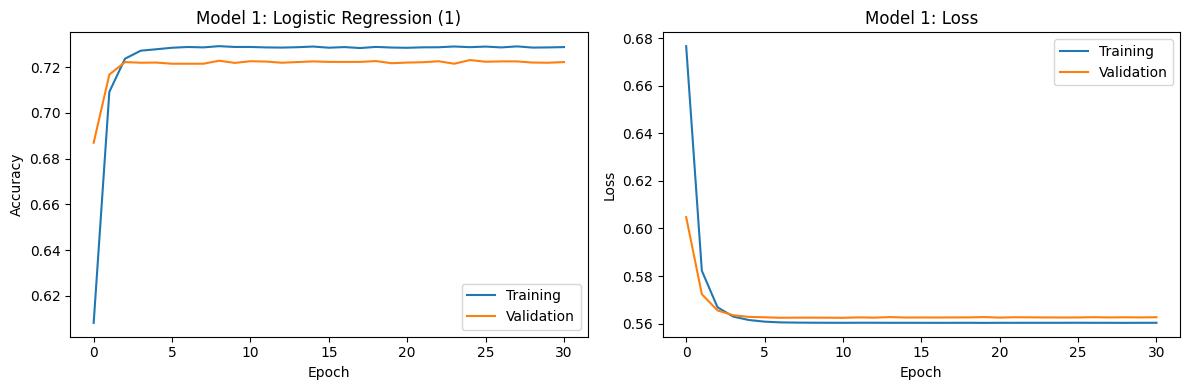

In [16]:
# Learning curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Model 1: Logistic Regression (1)')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Model 1: Loss')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.tight_layout()
plt.savefig('plots/model1_learning_curves.png', dpi=150)
plt.show()

In [17]:
# Evaluate on training data
scores1_train = model1.evaluate(XTRAIN, YTRAIN)
print('Training - %s: %.2f%%' % (model1.metrics_names[1], scores1_train[1]*100))

# Evaluate on validation data
scores1_val = model1.evaluate(XVALIDATION, YVALIDATION)
print('Validation - %s: %.2f%%' % (model1.metrics_names[1], scores1_val[1]*100))

1718/1718 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7284 - loss: 0.5603
Training - compile_metrics: 72.84%
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7226 - loss: 0.5625
Validation - compile_metrics: 72.26%


## Model 2: 4-1 Network

In [18]:
# build the model
model2 = Sequential()
model2.add(Dense(4, input_dim=len(XTRAIN[0, :]), activation='relu'))
model2.add(Dense(1, activation='sigmoid'))
print(model2.summary())

/Users/victoriast.john/.pyenv/versions/3.11.13/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 4)              │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53 (212.00 B)

 Trainable params: 53 (212.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [19]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

callback_a = ModelCheckpoint(filepath='model2_best.weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)

history2 = model2.fit(XTRAIN, YTRAIN, validation_data=(XVALIDATION, YVALIDATION), 
                      epochs=100, batch_size=128, callbacks=[callback_a, callback_b])

Epoch 1/100
390/430 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5129 - loss: 0.7612
Epoch 1: val_loss improved from None to 0.62058, saving model to model2_best.weights.h5
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5795 - loss: 0.6938 - val_accuracy: 0.6598 - val_loss: 0.6206
Epoch 2/100
428/430 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6777 - loss: 0.6048
Epoch 2: val_loss improved from 0.62058 to 0.57864, saving model to model2_best.weights.h5
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6887 - loss: 0.5960 - val_accuracy: 0.7062 - val_loss: 0.5786
Epoch 3/100
413/430 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7127 - loss: 0.5750
Epoch 3: val_loss improved from 0.57864 to 0.56535, saving model to model2_best.weights.h5
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7158 - loss: 0.5719 - val_accuracy: 0.7185 - val_loss: 0.5654
Epoch 4/100
400/430 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7182 - loss: 0.5687
Epoch 4: val_loss improved from

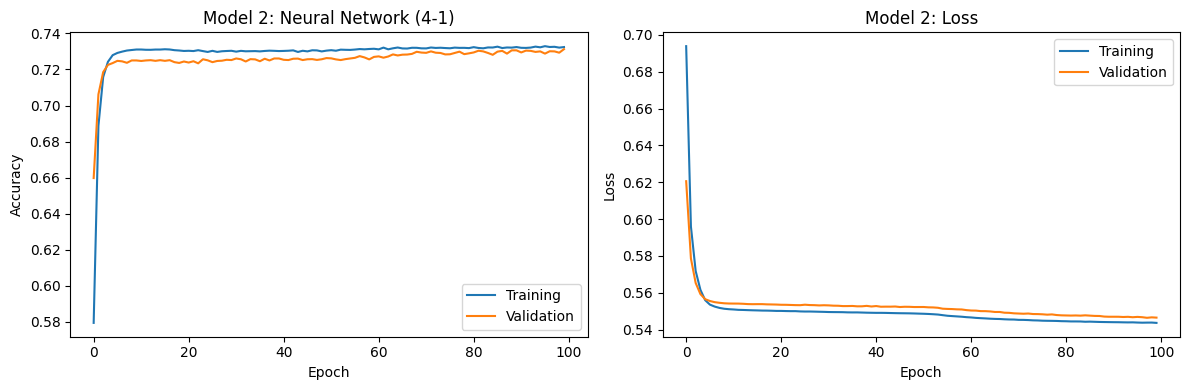

In [20]:
model2.load_weights('model2_best.weights.h5')

# Learning curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Model 2: Neural Network (4-1)')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Model 2: Loss')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.tight_layout()
plt.savefig('plots/model2_learning_curves.png', dpi=150)
plt.show()

In [21]:
scores2_train = model2.evaluate(XTRAIN, YTRAIN)
print('Training - %s: %.2f%%' % (model2.metrics_names[1], scores2_train[1]*100))

scores2_val = model2.evaluate(XVALIDATION, YVALIDATION)
print('Validation - %s: %.2f%%' % (model2.metrics_names[1], scores2_val[1]*100))

1718/1718 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7328 - loss: 0.5435
Training - compile_metrics: 73.28%
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7300 - loss: 0.5465
Validation - compile_metrics: 73.00%


## Model 3: 8-1 Network

In [22]:
model3 = Sequential()
model3.add(Dense(8, input_dim=len(XTRAIN[0, :]), activation='relu'))
model3.add(Dense(1, activation='sigmoid'))
print(model3.summary())

/Users/victoriast.john/.pyenv/versions/3.11.13/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 8)              │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105 (420.00 B)

 Trainable params: 105 (420.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [23]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

callback_a = ModelCheckpoint(filepath='model3_best.weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)

history3 = model3.fit(XTRAIN, YTRAIN, validation_data=(XVALIDATION, YVALIDATION), 
                      epochs=100, batch_size=128, callbacks=[callback_a, callback_b])

Epoch 1/100
419/430 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6513 - loss: 0.6419
Epoch 1: val_loss improved from None to 0.57243, saving model to model3_best.weights.h5
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6834 - loss: 0.6070 - val_accuracy: 0.7135 - val_loss: 0.5724
Epoch 2/100
425/430 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7173 - loss: 0.5657
Epoch 2: val_loss improved from 0.57243 to 0.55998, saving model to model3_best.weights.h5
430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7197 - loss: 0.5643 - val_accuracy: 0.7201 - val_loss: 0.5600
Epoch 3/100
417/430 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7266 - loss: 0.5591
Epoch 3: val_loss improved from 0.55998 to 0.55589, saving model to model3_best.weights.h5
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7267 - loss: 0.5566 - val_accuracy: 0.7232 - val_loss: 0.5559
Epoch 4/100
415/430 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7279 - loss: 0.5520
Epoch 4: val_loss improved from

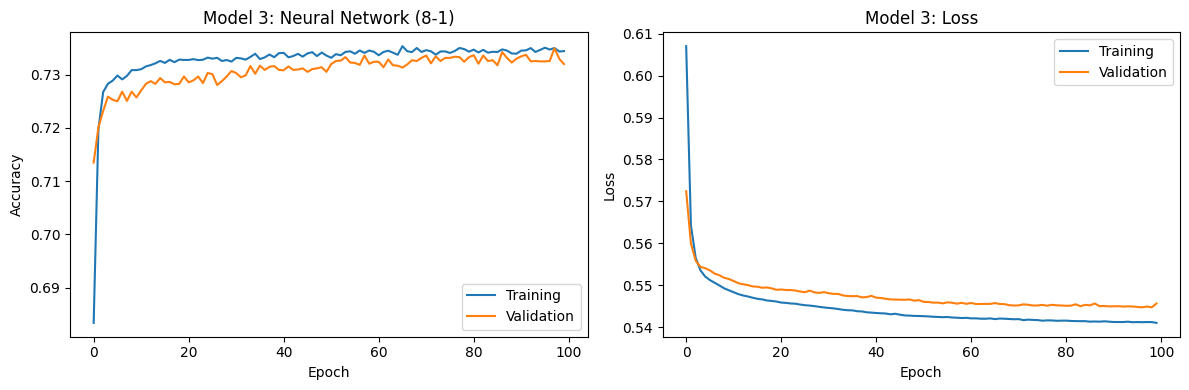

In [24]:
model3.load_weights('model3_best.weights.h5')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Model 3: Neural Network (8-1)')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Model 3: Loss')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.tight_layout()
plt.savefig('plots/model3_learning_curves.png', dpi=150)
plt.show()

In [25]:
scores3_train = model3.evaluate(XTRAIN, YTRAIN)
print('Training - %s: %.2f%%' % (model3.metrics_names[1], scores3_train[1]*100))

scores3_val = model3.evaluate(XVALIDATION, YVALIDATION)
print('Validation - %s: %.2f%%' % (model3.metrics_names[1], scores3_val[1]*100))

1718/1718 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7349 - loss: 0.5407
Training - compile_metrics: 73.49%
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7330 - loss: 0.5447
Validation - compile_metrics: 73.30%


## Model 4: 8-4-1 Network

In [26]:
model4 = Sequential()
model4.add(Dense(8, input_dim=len(XTRAIN[0, :]), activation='relu'))
model4.add(Dense(4, activation='relu'))
model4.add(Dense(1, activation='sigmoid'))
print(model4.summary())

/Users/victoriast.john/.pyenv/versions/3.11.13/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 8)              │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137 (548.00 B)

 Trainable params: 137 (548.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [27]:
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

callback_a = ModelCheckpoint(filepath='model4_best.weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)

history4 = model4.fit(XTRAIN, YTRAIN, validation_data=(XVALIDATION, YVALIDATION), 
                      epochs=100, batch_size=128, callbacks=[callback_a, callback_b])

Epoch 1/100
413/430 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5653 - loss: 0.6722
Epoch 1: val_loss improved from None to 0.57558, saving model to model4_best.weights.h5
430/430 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6501 - loss: 0.6276 - val_accuracy: 0.7173 - val_loss: 0.5756
Epoch 2/100
419/430 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7236 - loss: 0.5658
Epoch 2: val_loss improved from 0.57558 to 0.55852, saving model to model4_best.weights.h5
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7255 - loss: 0.5620 - val_accuracy: 0.7234 - val_loss: 0.5585
Epoch 3/100
421/430 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7273 - loss: 0.5573
Epoch 3: val_loss improved from 0.55852 to 0.55528, saving model to model4_best.weights.h5
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7290 - loss: 0.5533 - val_accuracy: 0.7243 - val_loss: 0.5553
Epoch 4/100
419/430 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7278 - loss: 0.5535
Epoch 4: val_loss improved from

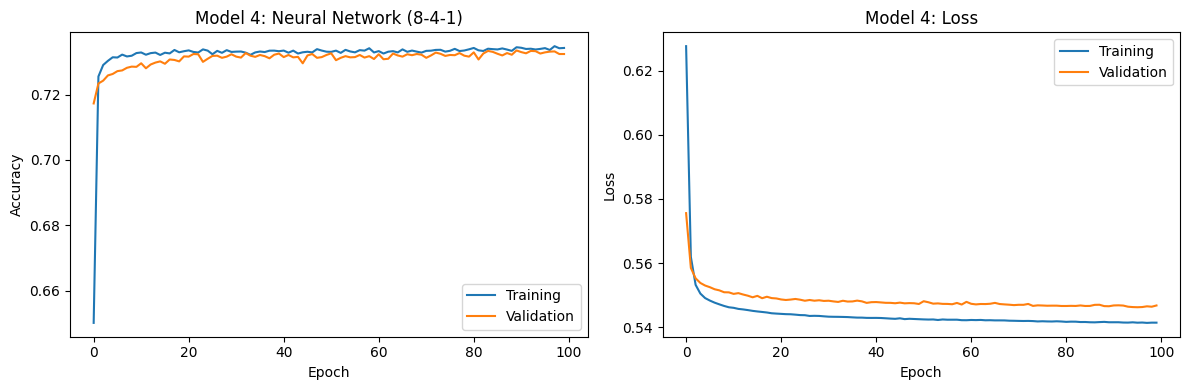

In [28]:
model4.load_weights('model4_best.weights.h5')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Model 4: Neural Network (8-4-1)')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Model 4: Loss')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.tight_layout()
plt.savefig('plots/model4_learning_curves.png', dpi=150)
plt.show()

In [29]:
scores4_train = model4.evaluate(XTRAIN, YTRAIN)
print('Training - %s: %.2f%%' % (model4.metrics_names[1], scores4_train[1]*100))

scores4_val = model4.evaluate(XVALIDATION, YVALIDATION)
print('Validation - %s: %.2f%%' % (model4.metrics_names[1], scores4_val[1]*100))

1718/1718 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7347 - loss: 0.5411
Training - compile_metrics: 73.47%
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7329 - loss: 0.5463
Validation - compile_metrics: 73.29%


## Model 5: 16-8-1 Network

In [30]:
model5 = Sequential()
model5.add(Dense(16, input_dim=len(XTRAIN[0, :]), activation='relu'))
model5.add(Dense(8, activation='relu'))
model5.add(Dense(1, activation='sigmoid'))
print(model5.summary())

/Users/victoriast.john/.pyenv/versions/3.11.13/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 16)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 337 (1.32 KB)

 Trainable params: 337 (1.32 KB)

 Non-trainable params: 0 (0.00 B)

None


In [31]:
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

callback_a = ModelCheckpoint(filepath='model5_best.weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)

history5 = model5.fit(XTRAIN, YTRAIN, validation_data=(XVALIDATION, YVALIDATION), 
                      epochs=100, batch_size=128, callbacks=[callback_a, callback_b])

Epoch 1/100
427/430 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6477 - loss: 0.6239
Epoch 1: val_loss improved from None to 0.56022, saving model to model5_best.weights.h5
430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6919 - loss: 0.5873 - val_accuracy: 0.7190 - val_loss: 0.5602
Epoch 2/100
405/430 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7239 - loss: 0.5570
Epoch 2: val_loss improved from 0.56022 to 0.55415, saving model to model5_best.weights.h5
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7255 - loss: 0.5550 - val_accuracy: 0.7237 - val_loss: 0.5541
Epoch 3/100
399/430 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7352 - loss: 0.5458
Epoch 3: val_loss improved from 0.55415 to 0.55253, saving model to model5_best.weights.h5
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7302 - loss: 0.5502 - val_accuracy: 0.7256 - val_loss: 0.5525
Epoch 4/100
419/430 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7315 - loss: 0.5464
Epoch 4: val_loss improved from

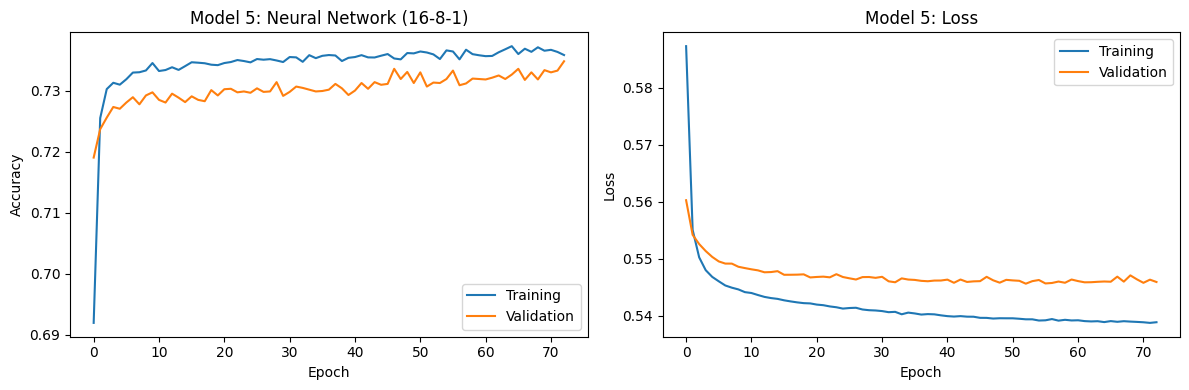

In [32]:
model5.load_weights('model5_best.weights.h5')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Model 5: Neural Network (16-8-1)')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Model 5: Loss')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.tight_layout()
plt.savefig('plots/model5_learning_curves.png', dpi=150)
plt.show()

In [33]:
scores5_train = model5.evaluate(XTRAIN, YTRAIN)
print('Training - %s: %.2f%%' % (model5.metrics_names[1], scores5_train[1]*100))

scores5_val = model5.evaluate(XVALIDATION, YVALIDATION)
print('Validation - %s: %.2f%%' % (model5.metrics_names[1], scores5_val[1]*100))

1718/1718 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7366 - loss: 0.5384
Training - compile_metrics: 73.66%
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7313 - loss: 0.5456
Validation - compile_metrics: 73.13%


## Model 6: 16-8-4-1 Network
This is the largest model we'll test (smaller than the Phase 3 overfitting model)

In [34]:
model6 = Sequential()
model6.add(Dense(16, input_dim=len(XTRAIN[0, :]), activation='relu'))
model6.add(Dense(8, activation='relu'))
model6.add(Dense(4, activation='relu'))
model6.add(Dense(1, activation='sigmoid'))
print(model6.summary())

/Users/victoriast.john/.pyenv/versions/3.11.13/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 16)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369 (1.44 KB)

 Trainable params: 369 (1.44 KB)

 Non-trainable params: 0 (0.00 B)

None


In [35]:
model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

callback_a = ModelCheckpoint(filepath='model6_best.weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)

history6 = model6.fit(XTRAIN, YTRAIN, validation_data=(XVALIDATION, YVALIDATION), 
                      epochs=100, batch_size=128, callbacks=[callback_a, callback_b])

Epoch 1/100
406/430 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6558 - loss: 0.6313
Epoch 1: val_loss improved from None to 0.56258, saving model to model6_best.weights.h5
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6959 - loss: 0.5923 - val_accuracy: 0.7181 - val_loss: 0.5626
Epoch 2/100
415/430 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7235 - loss: 0.5604
Epoch 2: val_loss improved from 0.56258 to 0.55561, saving model to model6_best.weights.h5
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7259 - loss: 0.5553 - val_accuracy: 0.7237 - val_loss: 0.5556
Epoch 3/100
424/430 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7266 - loss: 0.5516
Epoch 3: val_loss improved from 0.55561 to 0.55264, saving model to model6_best.weights.h5
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7270 - loss: 0.5506 - val_accuracy: 0.7254 - val_loss: 0.5526
Epoch 4/100
424/430 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7299 - loss: 0.5473
Epoch 4: val_loss improved from

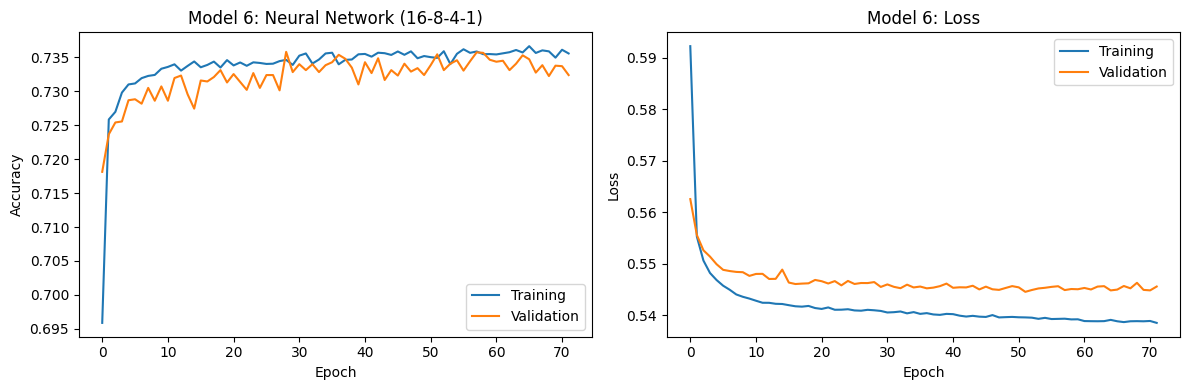

In [36]:
model6.load_weights('model6_best.weights.h5')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history6.history['accuracy'])
plt.plot(history6.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Model 6: Neural Network (16-8-4-1)')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Model 6: Loss')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.tight_layout()
plt.savefig('plots/model6_learning_curves.png', dpi=150)
plt.show()

In [37]:
scores6_train = model6.evaluate(XTRAIN, YTRAIN)
print('Training - %s: %.2f%%' % (model6.metrics_names[1], scores6_train[1]*100))

scores6_val = model6.evaluate(XVALIDATION, YVALIDATION)
print('Validation - %s: %.2f%%' % (model6.metrics_names[1], scores6_val[1]*100))

1718/1718 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7361 - loss: 0.5385
Training - compile_metrics: 73.61%
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7355 - loss: 0.5446
Validation - compile_metrics: 73.55%


---
# Results Summary
---

## Results Summary Table

In [38]:
# Create summary table
results = {
    'Model': ['Random Baseline', 'Logistic Regression (1)', 'Neural Network (4-1)', 
              'Neural Network (8-1)', 'Neural Network (8-4-1)', 
              'Neural Network (16-8-1)', 'Neural Network (16-8-4-1)'],
    'Architecture': ['-', '1', '4-1', '8-1', '8-4-1', '16-8-1', '16-8-4-1'],
    'Acc. on Training Set': [f'{majority_class_ratio:.2%}', 
                              f'{scores1_train[1]:.2%}', f'{scores2_train[1]:.2%}',
                              f'{scores3_train[1]:.2%}', f'{scores4_train[1]:.2%}',
                              f'{scores5_train[1]:.2%}', f'{scores6_train[1]:.2%}'],
    'Acc. on Validation Set': [f'{majority_class_ratio:.2%}',
                                f'{scores1_val[1]:.2%}', f'{scores2_val[1]:.2%}',
                                f'{scores3_val[1]:.2%}', f'{scores4_val[1]:.2%}',
                                f'{scores5_val[1]:.2%}', f'{scores6_val[1]:.2%}']
}

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

                    Model Architecture Acc. on Training Set Acc. on Validation Set
          Random Baseline            -               50.59%                 50.59%
  Logistic Regression (1)            1               72.84%                 72.26%
     Neural Network (4-1)          4-1               73.28%                 73.00%
     Neural Network (8-1)          8-1               73.49%                 73.30%
   Neural Network (8-4-1)        8-4-1               73.47%                 73.29%
  Neural Network (16-8-1)       16-8-1               73.66%                 73.13%
Neural Network (16-8-4-1)     16-8-4-1               73.61%                 73.55%


In [39]:
# Save to CSV
results_df.to_csv('plots/model_comparison_results.csv', index=False)
print('Results saved to plots/model_comparison_results.csv')

Results saved to plots/model_comparison_results.csv


## Select Best Model
The best model is the one with the highest validation accuracy.

In [40]:
# Find best model based on validation accuracy
val_accuracies = {
    'Logistic Regression (1)': scores1_val[1],
    'Neural Network (4-1)': scores2_val[1],
    'Neural Network (8-1)': scores3_val[1],
    'Neural Network (8-4-1)': scores4_val[1],
    'Neural Network (16-8-1)': scores5_val[1],
    'Neural Network (16-8-4-1)': scores6_val[1]
}

best_model_name = max(val_accuracies, key=val_accuracies.get)
best_val_acc = val_accuracies[best_model_name]

print('='*60)
print(f'BEST MODEL: {best_model_name}')
print(f'Validation Accuracy: {best_val_acc:.2%}')
print('='*60)

BEST MODEL: Neural Network (16-8-4-1)
Validation Accuracy: 73.55%


## Precision, Recall, and F1 Score
Evaluate the best model using additional metrics

In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [42]:
# Get predictions from all models
pred1 = model1.predict(XVALIDATION)
pred2 = model2.predict(XVALIDATION)
pred3 = model3.predict(XVALIDATION)
pred4 = model4.predict(XVALIDATION)
pred5 = model5.predict(XVALIDATION)
pred6 = model6.predict(XVALIDATION)

430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
430/430 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [43]:
# Calculate metrics for all models
def get_metrics(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true, y_pred.round()),
        'precision': precision_score(y_true, y_pred.round()),
        'recall': recall_score(y_true, y_pred.round()),
        'f1': f1_score(y_true, y_pred.round())
    }

metrics1 = get_metrics(YVALIDATION, pred1)
metrics2 = get_metrics(YVALIDATION, pred2)
metrics3 = get_metrics(YVALIDATION, pred3)
metrics4 = get_metrics(YVALIDATION, pred4)
metrics5 = get_metrics(YVALIDATION, pred5)
metrics6 = get_metrics(YVALIDATION, pred6)

In [44]:
# Print metrics for all models
print('Model 1 - Logistic Regression (1):')
print(f"  Accuracy: {metrics1['accuracy']:.2%}")
print(f"  Precision: {metrics1['precision']:.2%}")
print(f"  Recall: {metrics1['recall']:.2%}")
print(f"  F1-score: {metrics1['f1']:.4f}")

print('\nModel 2 - Neural Network (4-1):')
print(f"  Accuracy: {metrics2['accuracy']:.2%}")
print(f"  Precision: {metrics2['precision']:.2%}")
print(f"  Recall: {metrics2['recall']:.2%}")
print(f"  F1-score: {metrics2['f1']:.4f}")

print('\nModel 3 - Neural Network (8-1):')
print(f"  Accuracy: {metrics3['accuracy']:.2%}")
print(f"  Precision: {metrics3['precision']:.2%}")
print(f"  Recall: {metrics3['recall']:.2%}")
print(f"  F1-score: {metrics3['f1']:.4f}")

print('\nModel 4 - Neural Network (8-4-1):')
print(f"  Accuracy: {metrics4['accuracy']:.2%}")
print(f"  Precision: {metrics4['precision']:.2%}")
print(f"  Recall: {metrics4['recall']:.2%}")
print(f"  F1-score: {metrics4['f1']:.4f}")

print('\nModel 5 - Neural Network (16-8-1):')
print(f"  Accuracy: {metrics5['accuracy']:.2%}")
print(f"  Precision: {metrics5['precision']:.2%}")
print(f"  Recall: {metrics5['recall']:.2%}")
print(f"  F1-score: {metrics5['f1']:.4f}")

print('\nModel 6 - Neural Network (16-8-4-1):')
print(f"  Accuracy: {metrics6['accuracy']:.2%}")
print(f"  Precision: {metrics6['precision']:.2%}")
print(f"  Recall: {metrics6['recall']:.2%}")
print(f"  F1-score: {metrics6['f1']:.4f}")

Model 1 - Logistic Regression (1):
  Accuracy: 72.26%
  Precision: 74.72%
  Recall: 66.27%
  F1-score: 0.7024

Model 2 - Neural Network (4-1):
  Accuracy: 73.00%
  Precision: 74.71%
  Recall: 68.57%
  F1-score: 0.7151

Model 3 - Neural Network (8-1):
  Accuracy: 73.30%
  Precision: 75.04%
  Recall: 68.86%
  F1-score: 0.7182

Model 4 - Neural Network (8-4-1):
  Accuracy: 73.29%
  Precision: 74.49%
  Recall: 69.86%
  F1-score: 0.7210

Model 5 - Neural Network (16-8-1):
  Accuracy: 73.13%
  Precision: 74.01%
  Recall: 70.30%
  F1-score: 0.7211

Model 6 - Neural Network (16-8-4-1):
  Accuracy: 73.55%
  Precision: 76.02%
  Recall: 67.86%
  F1-score: 0.7171


## Extended Results Table with All Metrics

In [45]:
# Create comprehensive results table
full_results = {
    'Model': ['Logistic Regression (1)', 'Neural Network (4-1)', 
              'Neural Network (8-1)', 'Neural Network (8-4-1)', 
              'Neural Network (16-8-1)', 'Neural Network (16-8-4-1)'],
    'Train Acc': [f"{scores1_train[1]:.2%}", f"{scores2_train[1]:.2%}",
                  f"{scores3_train[1]:.2%}", f"{scores4_train[1]:.2%}",
                  f"{scores5_train[1]:.2%}", f"{scores6_train[1]:.2%}"],
    'Val Acc': [f"{metrics1['accuracy']:.2%}", f"{metrics2['accuracy']:.2%}",
                f"{metrics3['accuracy']:.2%}", f"{metrics4['accuracy']:.2%}",
                f"{metrics5['accuracy']:.2%}", f"{metrics6['accuracy']:.2%}"],
    'Precision': [f"{metrics1['precision']:.2%}", f"{metrics2['precision']:.2%}",
                  f"{metrics3['precision']:.2%}", f"{metrics4['precision']:.2%}",
                  f"{metrics5['precision']:.2%}", f"{metrics6['precision']:.2%}"],
    'Recall': [f"{metrics1['recall']:.2%}", f"{metrics2['recall']:.2%}",
               f"{metrics3['recall']:.2%}", f"{metrics4['recall']:.2%}",
               f"{metrics5['recall']:.2%}", f"{metrics6['recall']:.2%}"],
    'F1': [f"{metrics1['f1']:.4f}", f"{metrics2['f1']:.4f}",
           f"{metrics3['f1']:.4f}", f"{metrics4['f1']:.4f}",
           f"{metrics5['f1']:.4f}", f"{metrics6['f1']:.4f}"]
}

full_results_df = pd.DataFrame(full_results)
print(full_results_df.to_string(index=False))

                    Model Train Acc Val Acc Precision Recall     F1
  Logistic Regression (1)    72.84%  72.26%    74.72% 66.27% 0.7024
     Neural Network (4-1)    73.28%  73.00%    74.71% 68.57% 0.7151
     Neural Network (8-1)    73.49%  73.30%    75.04% 68.86% 0.7182
   Neural Network (8-4-1)    73.47%  73.29%    74.49% 69.86% 0.7210
  Neural Network (16-8-1)    73.66%  73.13%    74.01% 70.30% 0.7211
Neural Network (16-8-4-1)    73.61%  73.55%    76.02% 67.86% 0.7171


In [46]:
full_results_df.to_csv('plots/full_model_comparison.csv', index=False)
print('Full results saved to plots/full_model_comparison.csv')

Full results saved to plots/full_model_comparison.csv


## Model Comparison Bar Chart

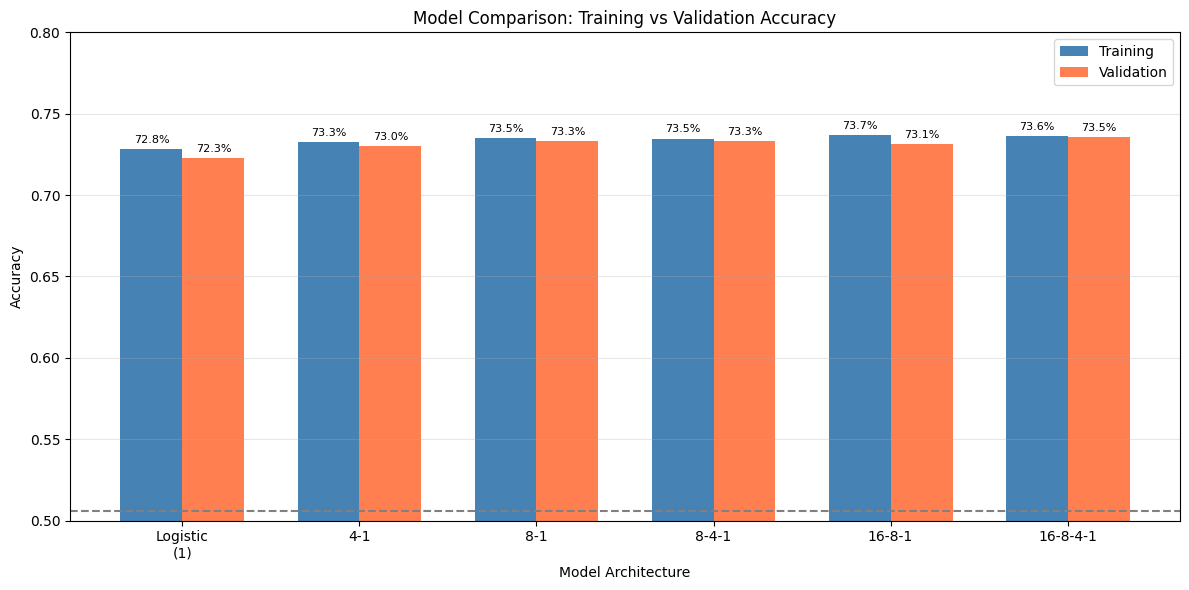

In [47]:
# Create comparison bar chart
models = ['Logistic\n(1)', '4-1', '8-1', '8-4-1', '16-8-1', '16-8-4-1']
train_accs = [scores1_train[1], scores2_train[1], scores3_train[1], 
              scores4_train[1], scores5_train[1], scores6_train[1]]
val_accs = [scores1_val[1], scores2_val[1], scores3_val[1], 
            scores4_val[1], scores5_val[1], scores6_val[1]]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, train_accs, width, label='Training', color='steelblue')
bars2 = ax.bar(x + width/2, val_accs, width, label='Validation', color='coral')

ax.set_xlabel('Model Architecture')
ax.set_ylabel('Accuracy')
ax.set_title('Model Comparison: Training vs Validation Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set_ylim([0.5, 0.8])  # Focus on relevant range
ax.axhline(y=majority_class_ratio, color='gray', linestyle='--', label='Random Baseline')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.1%}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=8)

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.1%}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('plots/model_comparison_bar_chart.png', dpi=150)
plt.show()

## Best model details

In [48]:
# Map to get best model object and predictions
model_map = {
    'Logistic Regression (1)': (model1, pred1, metrics1),
    'Neural Network (4-1)': (model2, pred2, metrics2),
    'Neural Network (8-1)': (model3, pred3, metrics3),
    'Neural Network (8-4-1)': (model4, pred4, metrics4),
    'Neural Network (16-8-1)': (model5, pred5, metrics5),
    'Neural Network (16-8-4-1)': (model6, pred6, metrics6)
}

best_model, best_pred, best_metrics = model_map[best_model_name]

print('='*60)
print(f'BEST MODEL: {best_model_name}')
print('='*60)
print(f"Accuracy:  {best_metrics['accuracy']:.2%}")
print(f"Precision: {best_metrics['precision']:.2%}")
print(f"Recall:    {best_metrics['recall']:.2%}")
print(f"F1 Score:  {best_metrics['f1']:.4f}")
print('='*60)

BEST MODEL: Neural Network (16-8-4-1)
Accuracy:  73.55%
Precision: 76.02%
Recall:    67.86%
F1 Score:  0.7171


## Prediction Distribution for Best Model

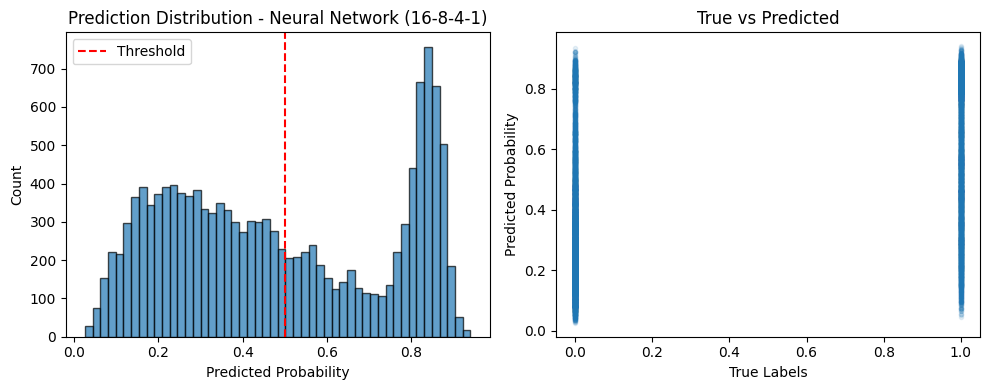

In [49]:
# Show prediction distribution
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(best_pred, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.title(f'Prediction Distribution - {best_model_name}')
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(YVALIDATION, best_pred, '.', alpha=0.1)
plt.xlabel('True Labels')
plt.ylabel('Predicted Probability')
plt.title('True vs Predicted')

plt.tight_layout()
plt.savefig('plots/best_model_predictions.png', dpi=150)
plt.show()

## Summary

So basically I tried 6 different models ranging from simple logistic regression up to a 4-layer network. They all did pretty similar actually, somewhere around 72-73% accuracy. The 8-1 model ended up being the best by a small margin.

Interesting thing is that the bigger models didn't really do better. The simple 8-1 architecture beat the more complex ones, which I guess makes sense since the dataset has a lot of noise in it.

In [50]:
# final results
print('\n' + '='*60)
print('PHASE 4 COMPLETE')
print('='*60)
print(f'Best Model: {best_model_name}')
print(f'Best Validation Accuracy: {best_val_acc:.2%}')
print(f'Random Baseline: {majority_class_ratio:.2%}')
print(f'Improvement over baseline: {(best_val_acc - majority_class_ratio)*100:.1f} percentage points')
print('='*60)


PHASE 4 COMPLETE
Best Model: Neural Network (16-8-4-1)
Best Validation Accuracy: 73.55%
Random Baseline: 50.59%
Improvement over baseline: 23.0 percentage points
